In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Input
from keras.models import Model, load_model
from keras.optimizers import adam_v2
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import set_random_seed
from tqdm import tqdm

from utils import rmse as calc_rmse
from utils import plot_loss

set_random_seed(42)

In [2]:
X, y = fetch_california_housing(return_X_y=True)
n = len(X)//10
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=n, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=n, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

In [3]:
def build_model(shape=8, lr=0.0001, activation="relu", out_activation=None):
    x = Input(shape=(shape))
    h = Dense(32, activation=activation)(x)
    h = Dense(16, activation=activation)(h)
    h = Dense(8, activation=activation)(h)
    h = Dense(4, activation=activation)(h)
    h = Dense(2, activation=activation)(h)
    out = Dense(1, activation=out_activation)(h)

    model = Model(inputs=x, outputs=out)
    
    lr_schedule = ExponentialDecay(
    lr,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)
    
    model.compile(loss="mse", optimizer=adam_v2.Adam(learning_rate=lr_schedule))
    return model

In [4]:
model = build_model(activation="relu", lr=0.0001)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 1)                 3     

2022-02-04 08:06:05.247463: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-02-04 08:06:05.247485: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ammar-desktop
2022-02-04 08:06:05.247489: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ammar-desktop
2022-02-04 08:06:05.247543: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.46.0
2022-02-04 08:06:05.247556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.46.0
2022-02-04 08:06:05.247560: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.46.0
2022-02-04 08:06:05.247837: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-c

In [5]:
from keras.callbacks import Callback
class SaveModelCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%10==0:
            self.model.save(f"Checkpoints/Epoch:{epoch}_loss:{logs['loss']}_valloss:{logs['val_loss']}")

In [6]:
es = EarlyStopping(patience=100, restore_best_weights=True)
H = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10000, batch_size=2752, callbacks=[SaveModelCallback(), es])

Epoch 1/10000
1/6 [====>.........................] - ETA: 3s - loss: 5.3002

2022-02-03 22:17:45.627736: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-02-03 22:17:45.876805: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Checkpoints/Epoch:0_loss:5.436062812805176_valloss:5.248269081115723/assets
6/6 [==============================] - 1s 122ms/step - loss: 5.4361 - val_loss: 5.2483
Epoch 2/10000
6/6 [==============================] - 0s 4ms/step - loss: 5.3971 - val_loss: 5.2081
Epoch 3/10000
6/6 [==============================] - 0s 4ms/step - loss: 5.3557 - val_loss: 5.1649
Epoch 4/10000
6/6 [==============================] - 0s 4ms/step - loss: 5.3112 - val_loss: 5.1177
Epoch 5/10000
6/6 [==============================] - 0s 4ms/step - loss: 5.2613 - val_loss: 5.0648
Epoch 6/10000
6/6 [==============================] - 0s 4ms/step - loss: 5.2062 - val_loss: 5.0078
Epoch 7/10000
6/6 [==============================] - 0s 4ms/step - loss: 5.1470 - val_loss: 4.9477
Epoch 8/10000
6/6 [==============================] - 0s 4ms/step - loss: 5.0847 - val_loss: 4.8851
Epoch 9/10000
6/6 [==============================] - 0s 4ms/step - loss: 5.0201 - val_loss: 4.8208
Epoch 10/1

6/6 [==============================] - 0s 4ms/step - loss: 1.1288 - val_loss: 1.1109
Epoch 141/10000
6/6 [==============================] - 0s 82ms/step - loss: 1.1266 - val_loss: 1.1089
Epoch 142/10000
6/6 [==============================] - 0s 4ms/step - loss: 1.1243 - val_loss: 1.1069
Epoch 143/10000
6/6 [==============================] - 0s 4ms/step - loss: 1.1221 - val_loss: 1.1049
Epoch 144/10000
6/6 [==============================] - 0s 4ms/step - loss: 1.1198 - val_loss: 1.1029
Epoch 145/10000
6/6 [==============================] - 0s 4ms/step - loss: 1.1176 - val_loss: 1.1008
Epoch 146/10000
6/6 [==============================] - 0s 4ms/step - loss: 1.1153 - val_loss: 1.0988
Epoch 147/10000
6/6 [==============================] - 0s 4ms/step - loss: 1.1130 - val_loss: 1.0968
Epoch 148/10000
6/6 [==============================] - 0s 4ms/step - loss: 1.1107 - val_loss: 1.0947
Epoch 149/10000
6/6 [==============================] - 0s 4ms/step - loss: 1.1084 - val_loss: 1.0926
Epoch

6/6 [==============================] - 0s 4ms/step - loss: 0.9440 - val_loss: 0.9442
Epoch 210/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.9405 - val_loss: 0.9410
Epoch 211/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.9371 - val_loss: 0.9378
Epoch 212/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.9335 - val_loss: 0.9345
Epoch 213/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.9300 - val_loss: 0.9312
Epoch 214/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.9264 - val_loss: 0.9278
Epoch 215/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.9228 - val_loss: 0.9245
Epoch 216/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.9192 - val_loss: 0.9210
Epoch 217/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.9154 - val_loss: 0.9175
Epoch 218/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.9116 - val_loss: 0.9140
Epoch

6/6 [==============================] - 0s 4ms/step - loss: 0.6822 - val_loss: 0.7055
Epoch 279/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.6795 - val_loss: 0.7030
Epoch 280/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.6768 - val_loss: 0.7006
Epoch 281/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.6741 - val_loss: 0.6982
Epoch 282/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.6715 - val_loss: 0.6959
Epoch 283/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.6689 - val_loss: 0.6936
Epoch 284/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.6665 - val_loss: 0.6914
Epoch 285/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.6639 - val_loss: 0.6891
Epoch 286/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.6615 - val_loss: 0.6870
Epoch 287/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.6591 - val_loss: 0.6848
Epoc

6/6 [==============================] - 0s 4ms/step - loss: 0.5842 - val_loss: 0.6203
Epoch 348/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5837 - val_loss: 0.6199
Epoch 349/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5833 - val_loss: 0.6195
Epoch 350/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5828 - val_loss: 0.6191
Epoch 351/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.5823 - val_loss: 0.6187
Epoch 352/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5819 - val_loss: 0.6184
Epoch 353/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5815 - val_loss: 0.6180
Epoch 354/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5811 - val_loss: 0.6177
Epoch 355/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.5807 - val_loss: 0.6173
Epoch 356/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5803 - val_loss: 0.6170
Epoch

6/6 [==============================] - 0s 4ms/step - loss: 0.5642 - val_loss: 0.6022
Epoch 417/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5640 - val_loss: 0.6020
Epoch 418/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5637 - val_loss: 0.6017
Epoch 419/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5635 - val_loss: 0.6015
Epoch 420/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5633 - val_loss: 0.6013
Epoch 421/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.5631 - val_loss: 0.6011
Epoch 422/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5629 - val_loss: 0.6009
Epoch 423/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5627 - val_loss: 0.6007
Epoch 424/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5625 - val_loss: 0.6004
Epoch 425/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5622 - val_loss: 0.6002
Epoch

6/6 [==============================] - 0s 4ms/step - loss: 0.5493 - val_loss: 0.5869
Epoch 486/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5491 - val_loss: 0.5867
Epoch 487/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5489 - val_loss: 0.5864
Epoch 488/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5486 - val_loss: 0.5862
Epoch 489/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5484 - val_loss: 0.5860
Epoch 490/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5482 - val_loss: 0.5858
Epoch 491/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.5480 - val_loss: 0.5855
Epoch 492/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5479 - val_loss: 0.5853
Epoch 493/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5475 - val_loss: 0.5851
Epoch 494/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5473 - val_loss: 0.5849
Epoch

6/6 [==============================] - 0s 4ms/step - loss: 0.5339 - val_loss: 0.5708
Epoch 555/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5336 - val_loss: 0.5706
Epoch 556/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5335 - val_loss: 0.5704
Epoch 557/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5331 - val_loss: 0.5701
Epoch 558/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5329 - val_loss: 0.5699
Epoch 559/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5327 - val_loss: 0.5696
Epoch 560/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5325 - val_loss: 0.5694
Epoch 561/10000
6/6 [==============================] - 0s 99ms/step - loss: 0.5322 - val_loss: 0.5692
Epoch 562/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5320 - val_loss: 0.5689
Epoch 563/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5318 - val_loss: 0.5687
Epoch

Epoch 623/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5177 - val_loss: 0.5541
Epoch 624/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5175 - val_loss: 0.5538
Epoch 625/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5172 - val_loss: 0.5536
Epoch 626/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5170 - val_loss: 0.5533
Epoch 627/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5168 - val_loss: 0.5531
Epoch 628/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5165 - val_loss: 0.5528
Epoch 629/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5163 - val_loss: 0.5526
Epoch 630/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5160 - val_loss: 0.5523
Epoch 631/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.5158 - val_loss: 0.5521
Epoch 632/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5156 - val_lo

Epoch 692/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5008 - val_loss: 0.5373
Epoch 693/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5005 - val_loss: 0.5370
Epoch 694/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5003 - val_loss: 0.5368
Epoch 695/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.5001 - val_loss: 0.5366
Epoch 696/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4998 - val_loss: 0.5363
Epoch 697/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4996 - val_loss: 0.5361
Epoch 698/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4994 - val_loss: 0.5359
Epoch 699/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4991 - val_loss: 0.5357
Epoch 700/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4989 - val_loss: 0.5354
Epoch 701/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.4987 - val_lo

6/6 [==============================] - 0s 84ms/step - loss: 0.4847 - val_loss: 0.5204
Epoch 762/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4845 - val_loss: 0.5201
Epoch 763/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4843 - val_loss: 0.5198
Epoch 764/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4840 - val_loss: 0.5196
Epoch 765/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4839 - val_loss: 0.5194
Epoch 766/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4837 - val_loss: 0.5192
Epoch 767/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4835 - val_loss: 0.5189
Epoch 768/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4832 - val_loss: 0.5188
Epoch 769/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4831 - val_loss: 0.5184
Epoch 770/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4828 - val_loss: 0.5182
Epoch

Epoch 900/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4610 - val_loss: 0.4941
Epoch 901/10000
6/6 [==============================] - 0s 87ms/step - loss: 0.4609 - val_loss: 0.4940
Epoch 902/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4606 - val_loss: 0.4939
Epoch 903/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4606 - val_loss: 0.4936
Epoch 904/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4604 - val_loss: 0.4935
Epoch 905/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4602 - val_loss: 0.4933
Epoch 906/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4601 - val_loss: 0.4932
Epoch 907/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4600 - val_loss: 0.4932
Epoch 908/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4599 - val_loss: 0.4929
Epoch 909/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4597 - val_lo

Epoch 969/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4525 - val_loss: 0.4851
Epoch 970/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4524 - val_loss: 0.4849
Epoch 971/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.4523 - val_loss: 0.4848
Epoch 972/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4521 - val_loss: 0.4845
Epoch 973/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4522 - val_loss: 0.4845
Epoch 974/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4524 - val_loss: 0.4848
Epoch 975/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4516 - val_loss: 0.4843
Epoch 976/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4519 - val_loss: 0.4840
Epoch 977/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4516 - val_loss: 0.4842
Epoch 978/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4514 - val_lo

6/6 [==============================] - 0s 4ms/step - loss: 0.4382 - val_loss: 0.4690
Epoch 1106/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4380 - val_loss: 0.4690
Epoch 1107/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4380 - val_loss: 0.4689
Epoch 1108/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4379 - val_loss: 0.4688
Epoch 1109/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4377 - val_loss: 0.4688
Epoch 1110/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4377 - val_loss: 0.4686
Epoch 1111/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.4375 - val_loss: 0.4685
Epoch 1112/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4375 - val_loss: 0.4685
Epoch 1113/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4375 - val_loss: 0.4683
Epoch 1114/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4373 - val_loss: 0.

Epoch 1242/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4270 - val_loss: 0.4569
Epoch 1243/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4270 - val_loss: 0.4567
Epoch 1244/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4269 - val_loss: 0.4566
Epoch 1245/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4270 - val_loss: 0.4567
Epoch 1246/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4268 - val_loss: 0.4566
Epoch 1247/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4268 - val_loss: 0.4566
Epoch 1248/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4267 - val_loss: 0.4562
Epoch 1249/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4268 - val_loss: 0.4563
Epoch 1250/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4264 - val_loss: 0.4565
Epoch 1251/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.426

6/6 [==============================] - 0s 3ms/step - loss: 0.4182 - val_loss: 0.4473
Epoch 1380/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4184 - val_loss: 0.4472
Epoch 1381/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.4181 - val_loss: 0.4470
Epoch 1382/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4179 - val_loss: 0.4473
Epoch 1383/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4179 - val_loss: 0.4469
Epoch 1384/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4179 - val_loss: 0.4469
Epoch 1385/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4179 - val_loss: 0.4468
Epoch 1386/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4177 - val_loss: 0.4471
Epoch 1387/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4176 - val_loss: 0.4466
Epoch 1388/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4176 - val_loss: 0.

6/6 [==============================] - 0s 3ms/step - loss: 0.4103 - val_loss: 0.4387
Epoch 1516/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4102 - val_loss: 0.4388
Epoch 1517/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4102 - val_loss: 0.4387
Epoch 1518/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4102 - val_loss: 0.4386
Epoch 1519/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4100 - val_loss: 0.4387
Epoch 1520/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4100 - val_loss: 0.4385
Epoch 1521/10000
6/6 [==============================] - 0s 82ms/step - loss: 0.4100 - val_loss: 0.4384
Epoch 1522/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4099 - val_loss: 0.4384
Epoch 1523/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4098 - val_loss: 0.4384
Epoch 1524/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4098 - val_loss: 0.4

Epoch 1652/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4033 - val_loss: 0.4314
Epoch 1653/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4036 - val_loss: 0.4313
Epoch 1654/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4036 - val_loss: 0.4312
Epoch 1655/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4033 - val_loss: 0.4314
Epoch 1656/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4030 - val_loss: 0.4312
Epoch 1657/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4033 - val_loss: 0.4316
Epoch 1658/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4033 - val_loss: 0.4309
Epoch 1659/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4031 - val_loss: 0.4310
Epoch 1660/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4029 - val_loss: 0.4311
Epoch 1661/10000
6/6 [==============================] - 0s 87ms/step - loss: 0.402

6/6 [==============================] - 0s 87ms/step - loss: 0.4002 - val_loss: 0.4280
Epoch 1722/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4002 - val_loss: 0.4281
Epoch 1723/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4002 - val_loss: 0.4281
Epoch 1724/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4002 - val_loss: 0.4280
Epoch 1725/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4001 - val_loss: 0.4278
Epoch 1726/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4001 - val_loss: 0.4278
Epoch 1727/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4001 - val_loss: 0.4278
Epoch 1728/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.4005 - val_loss: 0.4279
Epoch 1729/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.4002 - val_loss: 0.4276
Epoch 1730/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3998 - val_loss: 0.4

Epoch 1791/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.3974 - val_loss: 0.4251
Epoch 1792/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3974 - val_loss: 0.4248
Epoch 1793/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3973 - val_loss: 0.4250
Epoch 1794/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3973 - val_loss: 0.4247
Epoch 1795/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3972 - val_loss: 0.4248
Epoch 1796/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3971 - val_loss: 0.4248
Epoch 1797/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3972 - val_loss: 0.4251
Epoch 1798/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3973 - val_loss: 0.4246
Epoch 1799/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3973 - val_loss: 0.4249
Epoch 1800/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.396

6/6 [==============================] - 0s 3ms/step - loss: 0.3947 - val_loss: 0.4224
Epoch 1860/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3947 - val_loss: 0.4222
Epoch 1861/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.3947 - val_loss: 0.4224
Epoch 1862/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3947 - val_loss: 0.4225
Epoch 1863/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3947 - val_loss: 0.4221
Epoch 1864/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3946 - val_loss: 0.4222
Epoch 1865/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3946 - val_loss: 0.4222
Epoch 1866/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3945 - val_loss: 0.4222
Epoch 1867/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3944 - val_loss: 0.4220
Epoch 1868/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3944 - val_loss: 0.4

6/6 [==============================] - 0s 4ms/step - loss: 0.3899 - val_loss: 0.4172
Epoch 1996/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3898 - val_loss: 0.4172
Epoch 1997/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3898 - val_loss: 0.4170
Epoch 1998/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3898 - val_loss: 0.4169
Epoch 1999/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3898 - val_loss: 0.4170
Epoch 2000/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3897 - val_loss: 0.4170
Epoch 2001/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.3897 - val_loss: 0.4169
Epoch 2002/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3899 - val_loss: 0.4168
Epoch 2003/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3896 - val_loss: 0.4170
Epoch 2004/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3896 - val_loss: 0.4

Epoch 2132/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3854 - val_loss: 0.4124
Epoch 2133/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3853 - val_loss: 0.4121
Epoch 2134/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3853 - val_loss: 0.4126
Epoch 2135/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3852 - val_loss: 0.4122
Epoch 2136/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3852 - val_loss: 0.4122
Epoch 2137/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3852 - val_loss: 0.4123
Epoch 2138/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3851 - val_loss: 0.4120
Epoch 2139/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3852 - val_loss: 0.4122
Epoch 2140/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3851 - val_loss: 0.4121
Epoch 2141/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.385

6/6 [==============================] - 1s 101ms/step - loss: 0.3832 - val_loss: 0.4101
Epoch 2202/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3831 - val_loss: 0.4098
Epoch 2203/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3832 - val_loss: 0.4102
Epoch 2204/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3836 - val_loss: 0.4100
Epoch 2205/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3837 - val_loss: 0.4102
Epoch 2206/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3830 - val_loss: 0.4102
Epoch 2207/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3829 - val_loss: 0.4097
Epoch 2208/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3829 - val_loss: 0.4100
Epoch 2209/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3829 - val_loss: 0.4099
Epoch 2210/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3829 - val_loss: 0.

Epoch 2271/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.3810 - val_loss: 0.4083
Epoch 2272/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3811 - val_loss: 0.4079
Epoch 2273/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3808 - val_loss: 0.4078
Epoch 2274/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3808 - val_loss: 0.4077
Epoch 2275/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3808 - val_loss: 0.4076
Epoch 2276/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3808 - val_loss: 0.4076
Epoch 2277/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3807 - val_loss: 0.4076
Epoch 2278/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3808 - val_loss: 0.4077
Epoch 2279/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3807 - val_loss: 0.4078
Epoch 2280/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.380

6/6 [==============================] - 0s 3ms/step - loss: 0.3789 - val_loss: 0.4059
Epoch 2340/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3787 - val_loss: 0.4056
Epoch 2341/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.3787 - val_loss: 0.4057
Epoch 2342/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3786 - val_loss: 0.4056
Epoch 2343/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3786 - val_loss: 0.4057
Epoch 2344/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3786 - val_loss: 0.4056
Epoch 2345/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3786 - val_loss: 0.4058
Epoch 2346/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3785 - val_loss: 0.4055
Epoch 2347/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3786 - val_loss: 0.4056
Epoch 2348/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3785 - val_loss: 0.4

6/6 [==============================] - 0s 3ms/step - loss: 0.3744 - val_loss: 0.4015
Epoch 2476/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3744 - val_loss: 0.4013
Epoch 2477/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3744 - val_loss: 0.4012
Epoch 2478/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3745 - val_loss: 0.4013
Epoch 2479/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3742 - val_loss: 0.4013
Epoch 2480/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3744 - val_loss: 0.4012
Epoch 2481/10000
6/6 [==============================] - 0s 87ms/step - loss: 0.3744 - val_loss: 0.4011
Epoch 2482/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3742 - val_loss: 0.4013
Epoch 2483/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3741 - val_loss: 0.4011
Epoch 2484/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3741 - val_loss: 0.4

Epoch 2612/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3703 - val_loss: 0.3972
Epoch 2613/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3701 - val_loss: 0.3973
Epoch 2614/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3702 - val_loss: 0.3972
Epoch 2615/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3701 - val_loss: 0.3970
Epoch 2616/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3703 - val_loss: 0.3970
Epoch 2617/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3699 - val_loss: 0.3970
Epoch 2618/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3699 - val_loss: 0.3971
Epoch 2619/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3699 - val_loss: 0.3970
Epoch 2620/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3698 - val_loss: 0.3969
Epoch 2621/10000
6/6 [==============================] - 0s 87ms/step - loss: 0.369

6/6 [==============================] - 0s 86ms/step - loss: 0.3678 - val_loss: 0.3950
Epoch 2682/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3680 - val_loss: 0.3953
Epoch 2683/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3677 - val_loss: 0.3946
Epoch 2684/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3678 - val_loss: 0.3949
Epoch 2685/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3677 - val_loss: 0.3947
Epoch 2686/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3678 - val_loss: 0.3948
Epoch 2687/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3676 - val_loss: 0.3948
Epoch 2688/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3677 - val_loss: 0.3951
Epoch 2689/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3676 - val_loss: 0.3948
Epoch 2690/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3676 - val_loss: 0.3

Epoch 2751/10000
6/6 [==============================] - 0s 99ms/step - loss: 0.3656 - val_loss: 0.3932
Epoch 2752/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3656 - val_loss: 0.3932
Epoch 2753/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3656 - val_loss: 0.3929
Epoch 2754/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3657 - val_loss: 0.3927
Epoch 2755/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3657 - val_loss: 0.3928
Epoch 2756/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3655 - val_loss: 0.3928
Epoch 2757/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3655 - val_loss: 0.3930
Epoch 2758/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3655 - val_loss: 0.3929
Epoch 2759/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3654 - val_loss: 0.3929
Epoch 2760/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.365

6/6 [==============================] - 0s 4ms/step - loss: 0.3635 - val_loss: 0.3907
Epoch 2820/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3636 - val_loss: 0.3911
Epoch 2821/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.3637 - val_loss: 0.3910
Epoch 2822/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3637 - val_loss: 0.3911
Epoch 2823/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3634 - val_loss: 0.3907
Epoch 2824/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3633 - val_loss: 0.3909
Epoch 2825/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3634 - val_loss: 0.3906
Epoch 2826/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3635 - val_loss: 0.3912
Epoch 2827/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3632 - val_loss: 0.3910
Epoch 2828/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3632 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.3591 - val_loss: 0.3876
Epoch 2956/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3591 - val_loss: 0.3872
Epoch 2957/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3589 - val_loss: 0.3876
Epoch 2958/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3589 - val_loss: 0.3876
Epoch 2959/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3589 - val_loss: 0.3875
Epoch 2960/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3589 - val_loss: 0.3872
Epoch 2961/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.3589 - val_loss: 0.3871
Epoch 2962/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3588 - val_loss: 0.3872
Epoch 2963/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3588 - val_loss: 0.3874
Epoch 2964/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3587 - val_loss: 0.3

Epoch 3092/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3551 - val_loss: 0.3845
Epoch 3093/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3553 - val_loss: 0.3843
Epoch 3094/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3548 - val_loss: 0.3842
Epoch 3095/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3547 - val_loss: 0.3846
Epoch 3096/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3548 - val_loss: 0.3841
Epoch 3097/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3546 - val_loss: 0.3843
Epoch 3098/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3548 - val_loss: 0.3838
Epoch 3099/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3546 - val_loss: 0.3845
Epoch 3100/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3548 - val_loss: 0.3841
Epoch 3101/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.354

6/6 [==============================] - 0s 85ms/step - loss: 0.3528 - val_loss: 0.3822
Epoch 3162/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3527 - val_loss: 0.3825
Epoch 3163/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3528 - val_loss: 0.3827
Epoch 3164/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3527 - val_loss: 0.3825
Epoch 3165/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3527 - val_loss: 0.3823
Epoch 3166/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3527 - val_loss: 0.3820
Epoch 3167/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3527 - val_loss: 0.3825
Epoch 3168/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3527 - val_loss: 0.3823
Epoch 3169/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3525 - val_loss: 0.3824
Epoch 3170/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3525 - val_loss: 0.3

Epoch 3231/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.3510 - val_loss: 0.3814
Epoch 3232/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3507 - val_loss: 0.3807
Epoch 3233/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3508 - val_loss: 0.3812
Epoch 3234/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3507 - val_loss: 0.3805
Epoch 3235/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3508 - val_loss: 0.3809
Epoch 3236/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3508 - val_loss: 0.3803
Epoch 3237/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3508 - val_loss: 0.3810
Epoch 3238/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3507 - val_loss: 0.3804
Epoch 3239/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3506 - val_loss: 0.3807
Epoch 3240/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.350

6/6 [==============================] - 0s 4ms/step - loss: 0.3490 - val_loss: 0.3792
Epoch 3300/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3492 - val_loss: 0.3791
Epoch 3301/10000
6/6 [==============================] - 0s 100ms/step - loss: 0.3490 - val_loss: 0.3789
Epoch 3302/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3487 - val_loss: 0.3788
Epoch 3303/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3487 - val_loss: 0.3791
Epoch 3304/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3487 - val_loss: 0.3790
Epoch 3305/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3487 - val_loss: 0.3785
Epoch 3306/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3487 - val_loss: 0.3786
Epoch 3307/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3486 - val_loss: 0.3792
Epoch 3308/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3485 - val_loss: 0.

6/6 [==============================] - 0s 3ms/step - loss: 0.3451 - val_loss: 0.3755
Epoch 3436/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3451 - val_loss: 0.3757
Epoch 3437/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3451 - val_loss: 0.3755
Epoch 3438/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3450 - val_loss: 0.3755
Epoch 3439/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3452 - val_loss: 0.3762
Epoch 3440/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3452 - val_loss: 0.3755
Epoch 3441/10000
6/6 [==============================] - 0s 82ms/step - loss: 0.3452 - val_loss: 0.3758
Epoch 3442/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3451 - val_loss: 0.3752
Epoch 3443/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3450 - val_loss: 0.3760
Epoch 3444/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3454 - val_loss: 0.3

Epoch 3572/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3433 - val_loss: 0.3734
Epoch 3573/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3426 - val_loss: 0.3752
Epoch 3574/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3425 - val_loss: 0.3728
Epoch 3575/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3423 - val_loss: 0.3736
Epoch 3576/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3417 - val_loss: 0.3724
Epoch 3577/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3419 - val_loss: 0.3736
Epoch 3578/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3417 - val_loss: 0.3727
Epoch 3579/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3415 - val_loss: 0.3724
Epoch 3580/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3416 - val_loss: 0.3728
Epoch 3581/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.34

6/6 [==============================] - 0s 86ms/step - loss: 0.3403 - val_loss: 0.3710
Epoch 3642/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3403 - val_loss: 0.3712
Epoch 3643/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3401 - val_loss: 0.3716
Epoch 3644/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3400 - val_loss: 0.3712
Epoch 3645/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3401 - val_loss: 0.3716
Epoch 3646/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3398 - val_loss: 0.3709
Epoch 3647/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3399 - val_loss: 0.3715
Epoch 3648/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3398 - val_loss: 0.3714
Epoch 3649/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3400 - val_loss: 0.3712
Epoch 3650/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3398 - val_loss: 0.3

Epoch 3711/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.3384 - val_loss: 0.3694
Epoch 3712/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3384 - val_loss: 0.3703
Epoch 3713/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3384 - val_loss: 0.3701
Epoch 3714/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3383 - val_loss: 0.3701
Epoch 3715/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3382 - val_loss: 0.3694
Epoch 3716/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3382 - val_loss: 0.3698
Epoch 3717/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3382 - val_loss: 0.3693
Epoch 3718/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3383 - val_loss: 0.3696
Epoch 3719/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3383 - val_loss: 0.3702
Epoch 3720/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.338

6/6 [==============================] - 0s 3ms/step - loss: 0.3368 - val_loss: 0.3692
Epoch 3780/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3370 - val_loss: 0.3679
Epoch 3781/10000
6/6 [==============================] - 0s 87ms/step - loss: 0.3369 - val_loss: 0.3684
Epoch 3782/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3367 - val_loss: 0.3682
Epoch 3783/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3366 - val_loss: 0.3678
Epoch 3784/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3367 - val_loss: 0.3679
Epoch 3785/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3366 - val_loss: 0.3682
Epoch 3786/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3366 - val_loss: 0.3679
Epoch 3787/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3365 - val_loss: 0.3683
Epoch 3788/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3367 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.3337 - val_loss: 0.3650
Epoch 3916/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3336 - val_loss: 0.3646
Epoch 3917/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3339 - val_loss: 0.3663
Epoch 3918/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3337 - val_loss: 0.3642
Epoch 3919/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3335 - val_loss: 0.3655
Epoch 3920/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3333 - val_loss: 0.3645
Epoch 3921/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.3334 - val_loss: 0.3654
Epoch 3922/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3334 - val_loss: 0.3643
Epoch 3923/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3333 - val_loss: 0.3653
Epoch 3924/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3336 - val_loss: 0.3

Epoch 4052/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3310 - val_loss: 0.3616
Epoch 4053/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3309 - val_loss: 0.3625
Epoch 4054/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3308 - val_loss: 0.3612
Epoch 4055/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3302 - val_loss: 0.3620
Epoch 4056/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3302 - val_loss: 0.3615
Epoch 4057/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3304 - val_loss: 0.3621
Epoch 4058/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3305 - val_loss: 0.3612
Epoch 4059/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3303 - val_loss: 0.3618
Epoch 4060/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3304 - val_loss: 0.3615
Epoch 4061/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.330

6/6 [==============================] - 0s 84ms/step - loss: 0.3289 - val_loss: 0.3606
Epoch 4122/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3289 - val_loss: 0.3600
Epoch 4123/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3290 - val_loss: 0.3604
Epoch 4124/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3289 - val_loss: 0.3605
Epoch 4125/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3289 - val_loss: 0.3600
Epoch 4126/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3288 - val_loss: 0.3604
Epoch 4127/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3288 - val_loss: 0.3598
Epoch 4128/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3288 - val_loss: 0.3598
Epoch 4129/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3287 - val_loss: 0.3608
Epoch 4130/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3290 - val_loss: 0.3

Epoch 4191/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.3274 - val_loss: 0.3588
Epoch 4192/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3273 - val_loss: 0.3593
Epoch 4193/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3273 - val_loss: 0.3594
Epoch 4194/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3273 - val_loss: 0.3591
Epoch 4195/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3272 - val_loss: 0.3589
Epoch 4196/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3273 - val_loss: 0.3588
Epoch 4197/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3272 - val_loss: 0.3594
Epoch 4198/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3272 - val_loss: 0.3589
Epoch 4199/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3275 - val_loss: 0.3598
Epoch 4200/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.327

6/6 [==============================] - 0s 3ms/step - loss: 0.3263 - val_loss: 0.3580
Epoch 4260/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3261 - val_loss: 0.3585
Epoch 4261/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.3260 - val_loss: 0.3581
Epoch 4262/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3259 - val_loss: 0.3578
Epoch 4263/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3259 - val_loss: 0.3578
Epoch 4264/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3259 - val_loss: 0.3583
Epoch 4265/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3259 - val_loss: 0.3581
Epoch 4266/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3258 - val_loss: 0.3579
Epoch 4267/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3258 - val_loss: 0.3579
Epoch 4268/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3259 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.3241 - val_loss: 0.3562
Epoch 4396/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3235 - val_loss: 0.3554
Epoch 4397/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3235 - val_loss: 0.3552
Epoch 4398/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3233 - val_loss: 0.3557
Epoch 4399/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3232 - val_loss: 0.3554
Epoch 4400/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3232 - val_loss: 0.3551
Epoch 4401/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.3232 - val_loss: 0.3552
Epoch 4402/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3230 - val_loss: 0.3555
Epoch 4403/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3230 - val_loss: 0.3555
Epoch 4404/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3233 - val_loss: 0.

Epoch 4532/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3207 - val_loss: 0.3523
Epoch 4533/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3207 - val_loss: 0.3523
Epoch 4534/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3209 - val_loss: 0.3527
Epoch 4535/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3207 - val_loss: 0.3521
Epoch 4536/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3208 - val_loss: 0.3525
Epoch 4537/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3208 - val_loss: 0.3523
Epoch 4538/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3209 - val_loss: 0.3523
Epoch 4539/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3214 - val_loss: 0.3542
Epoch 4540/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3213 - val_loss: 0.3523
Epoch 4541/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.321

6/6 [==============================] - 0s 85ms/step - loss: 0.3203 - val_loss: 0.3510
Epoch 4602/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3199 - val_loss: 0.3528
Epoch 4603/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3204 - val_loss: 0.3505
Epoch 4604/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3194 - val_loss: 0.3507
Epoch 4605/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3194 - val_loss: 0.3509
Epoch 4606/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3193 - val_loss: 0.3507
Epoch 4607/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3194 - val_loss: 0.3509
Epoch 4608/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3194 - val_loss: 0.3503
Epoch 4609/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3195 - val_loss: 0.3506
Epoch 4610/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3193 - val_loss: 0.3

Epoch 4671/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.3182 - val_loss: 0.3495
Epoch 4672/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3183 - val_loss: 0.3492
Epoch 4673/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3183 - val_loss: 0.3494
Epoch 4674/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3181 - val_loss: 0.3492
Epoch 4675/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3182 - val_loss: 0.3490
Epoch 4676/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3180 - val_loss: 0.3494
Epoch 4677/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3182 - val_loss: 0.3497
Epoch 4678/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3182 - val_loss: 0.3495
Epoch 4679/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3181 - val_loss: 0.3490
Epoch 4680/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.31

6/6 [==============================] - 0s 3ms/step - loss: 0.3171 - val_loss: 0.3484
Epoch 4740/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3171 - val_loss: 0.3480
Epoch 4741/10000
6/6 [==============================] - 0s 82ms/step - loss: 0.3169 - val_loss: 0.3481
Epoch 4742/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3171 - val_loss: 0.3481
Epoch 4743/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3172 - val_loss: 0.3479
Epoch 4744/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3170 - val_loss: 0.3484
Epoch 4745/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3176 - val_loss: 0.3478
Epoch 4746/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3173 - val_loss: 0.3483
Epoch 4747/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3177 - val_loss: 0.3483
Epoch 4748/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3171 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.3157 - val_loss: 0.3461
Epoch 4876/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3153 - val_loss: 0.3458
Epoch 4877/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3150 - val_loss: 0.3455
Epoch 4878/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3150 - val_loss: 0.3459
Epoch 4879/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3150 - val_loss: 0.3459
Epoch 4880/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3150 - val_loss: 0.3462
Epoch 4881/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.3151 - val_loss: 0.3457
Epoch 4882/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3152 - val_loss: 0.3467
Epoch 4883/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3154 - val_loss: 0.3456
Epoch 4884/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3153 - val_loss: 0.3

Epoch 5012/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3131 - val_loss: 0.3439
Epoch 5013/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3131 - val_loss: 0.3442
Epoch 5014/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3132 - val_loss: 0.3441
Epoch 5015/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3130 - val_loss: 0.3445
Epoch 5016/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3131 - val_loss: 0.3441
Epoch 5017/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3131 - val_loss: 0.3443
Epoch 5018/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3130 - val_loss: 0.3444
Epoch 5019/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3130 - val_loss: 0.3437
Epoch 5020/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3131 - val_loss: 0.3439
Epoch 5021/10000
6/6 [==============================] - 0s 82ms/step - loss: 0.313

6/6 [==============================] - 0s 87ms/step - loss: 0.3121 - val_loss: 0.3434
Epoch 5082/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3122 - val_loss: 0.3436
Epoch 5083/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3125 - val_loss: 0.3441
Epoch 5084/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3122 - val_loss: 0.3433
Epoch 5085/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3120 - val_loss: 0.3435
Epoch 5086/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3121 - val_loss: 0.3433
Epoch 5087/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3120 - val_loss: 0.3436
Epoch 5088/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3120 - val_loss: 0.3442
Epoch 5089/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3125 - val_loss: 0.3437
Epoch 5090/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3124 - val_loss: 0.3

Epoch 5151/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.3117 - val_loss: 0.3429
Epoch 5152/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3117 - val_loss: 0.3436
Epoch 5153/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3112 - val_loss: 0.3428
Epoch 5154/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3111 - val_loss: 0.3432
Epoch 5155/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3113 - val_loss: 0.3430
Epoch 5156/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3114 - val_loss: 0.3450
Epoch 5157/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3115 - val_loss: 0.3437
Epoch 5158/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3122 - val_loss: 0.3457
Epoch 5159/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3121 - val_loss: 0.3432
Epoch 5160/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.312

6/6 [==============================] - 0s 3ms/step - loss: 0.3105 - val_loss: 0.3422
Epoch 5220/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3108 - val_loss: 0.3432
Epoch 5221/10000
6/6 [==============================] - 0s 82ms/step - loss: 0.3109 - val_loss: 0.3424
Epoch 5222/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3103 - val_loss: 0.3424
Epoch 5223/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3103 - val_loss: 0.3421
Epoch 5224/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3104 - val_loss: 0.3425
Epoch 5225/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3105 - val_loss: 0.3423
Epoch 5226/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3104 - val_loss: 0.3420
Epoch 5227/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3105 - val_loss: 0.3428
Epoch 5228/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3104 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.3089 - val_loss: 0.3410
Epoch 5356/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3088 - val_loss: 0.3413
Epoch 5357/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3090 - val_loss: 0.3412
Epoch 5358/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3088 - val_loss: 0.3408
Epoch 5359/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3088 - val_loss: 0.3414
Epoch 5360/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3089 - val_loss: 0.3407
Epoch 5361/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.3087 - val_loss: 0.3413
Epoch 5362/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3088 - val_loss: 0.3407
Epoch 5363/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3087 - val_loss: 0.3413
Epoch 5364/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3086 - val_loss: 0.3

Epoch 5492/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3074 - val_loss: 0.3397
Epoch 5493/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3072 - val_loss: 0.3399
Epoch 5494/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3074 - val_loss: 0.3397
Epoch 5495/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3074 - val_loss: 0.3400
Epoch 5496/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3074 - val_loss: 0.3408
Epoch 5497/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3077 - val_loss: 0.3395
Epoch 5498/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3074 - val_loss: 0.3396
Epoch 5499/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3074 - val_loss: 0.3412
Epoch 5500/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3073 - val_loss: 0.3397
Epoch 5501/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.30

6/6 [==============================] - 0s 90ms/step - loss: 0.3070 - val_loss: 0.3395
Epoch 5562/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3068 - val_loss: 0.3401
Epoch 5563/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3065 - val_loss: 0.3393
Epoch 5564/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3067 - val_loss: 0.3393
Epoch 5565/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3068 - val_loss: 0.3398
Epoch 5566/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3066 - val_loss: 0.3393
Epoch 5567/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3065 - val_loss: 0.3392
Epoch 5568/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3064 - val_loss: 0.3394
Epoch 5569/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3064 - val_loss: 0.3394
Epoch 5570/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3069 - val_loss: 0.3

Epoch 5631/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.3056 - val_loss: 0.3390
Epoch 5632/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3057 - val_loss: 0.3396
Epoch 5633/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3058 - val_loss: 0.3392
Epoch 5634/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3058 - val_loss: 0.3390
Epoch 5635/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3063 - val_loss: 0.3412
Epoch 5636/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3068 - val_loss: 0.3384
Epoch 5637/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3062 - val_loss: 0.3391
Epoch 5638/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3058 - val_loss: 0.3391
Epoch 5639/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3055 - val_loss: 0.3390
Epoch 5640/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.305

6/6 [==============================] - 0s 4ms/step - loss: 0.3049 - val_loss: 0.3384
Epoch 5700/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3047 - val_loss: 0.3391
Epoch 5701/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.3048 - val_loss: 0.3384
Epoch 5702/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3051 - val_loss: 0.3388
Epoch 5703/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3049 - val_loss: 0.3385
Epoch 5704/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3054 - val_loss: 0.3387
Epoch 5705/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3059 - val_loss: 0.3399
Epoch 5706/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3049 - val_loss: 0.3390
Epoch 5707/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3050 - val_loss: 0.3388
Epoch 5708/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3055 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.3038 - val_loss: 0.3383
Epoch 5836/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3035 - val_loss: 0.3377
Epoch 5837/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3035 - val_loss: 0.3379
Epoch 5838/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3034 - val_loss: 0.3379
Epoch 5839/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3034 - val_loss: 0.3378
Epoch 5840/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3034 - val_loss: 0.3380
Epoch 5841/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.3034 - val_loss: 0.3378
Epoch 5842/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3034 - val_loss: 0.3388
Epoch 5843/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3036 - val_loss: 0.3379
Epoch 5844/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3034 - val_loss: 0.3

Epoch 5972/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3019 - val_loss: 0.3377
Epoch 5973/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3020 - val_loss: 0.3369
Epoch 5974/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3019 - val_loss: 0.3372
Epoch 5975/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3018 - val_loss: 0.3369
Epoch 5976/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3019 - val_loss: 0.3371
Epoch 5977/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3019 - val_loss: 0.3370
Epoch 5978/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3018 - val_loss: 0.3375
Epoch 5979/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3018 - val_loss: 0.3367
Epoch 5980/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3019 - val_loss: 0.3374
Epoch 5981/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.301

6/6 [==============================] - 0s 85ms/step - loss: 0.3012 - val_loss: 0.3366
Epoch 6042/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3010 - val_loss: 0.3369
Epoch 6043/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3010 - val_loss: 0.3366
Epoch 6044/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3011 - val_loss: 0.3365
Epoch 6045/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3013 - val_loss: 0.3377
Epoch 6046/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3012 - val_loss: 0.3364
Epoch 6047/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.3011 - val_loss: 0.3368
Epoch 6048/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3009 - val_loss: 0.3369
Epoch 6049/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3009 - val_loss: 0.3364
Epoch 6050/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3008 - val_loss: 0.3

Epoch 6111/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.3004 - val_loss: 0.3362
Epoch 6112/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3003 - val_loss: 0.3362
Epoch 6113/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3001 - val_loss: 0.3361
Epoch 6114/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3003 - val_loss: 0.3358
Epoch 6115/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3000 - val_loss: 0.3361
Epoch 6116/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3001 - val_loss: 0.3362
Epoch 6117/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3008 - val_loss: 0.3365
Epoch 6118/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3005 - val_loss: 0.3366
Epoch 6119/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.3002 - val_loss: 0.3356
Epoch 6120/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.30

6/6 [==============================] - 0s 4ms/step - loss: 0.2997 - val_loss: 0.3361
Epoch 6180/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2995 - val_loss: 0.3358
Epoch 6181/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.2992 - val_loss: 0.3353
Epoch 6182/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2993 - val_loss: 0.3351
Epoch 6183/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2992 - val_loss: 0.3357
Epoch 6184/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2993 - val_loss: 0.3358
Epoch 6185/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2992 - val_loss: 0.3353
Epoch 6186/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2993 - val_loss: 0.3356
Epoch 6187/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2993 - val_loss: 0.3359
Epoch 6188/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2992 - val_loss: 0.3

6/6 [==============================] - 0s 4ms/step - loss: 0.2978 - val_loss: 0.3347
Epoch 6316/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2977 - val_loss: 0.3346
Epoch 6317/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2977 - val_loss: 0.3352
Epoch 6318/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2977 - val_loss: 0.3344
Epoch 6319/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2978 - val_loss: 0.3344
Epoch 6320/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2976 - val_loss: 0.3348
Epoch 6321/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.2976 - val_loss: 0.3352
Epoch 6322/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2978 - val_loss: 0.3345
Epoch 6323/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2976 - val_loss: 0.3346
Epoch 6324/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2977 - val_loss: 0.3

Epoch 6452/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2962 - val_loss: 0.3347
Epoch 6453/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2962 - val_loss: 0.3339
Epoch 6454/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2963 - val_loss: 0.3346
Epoch 6455/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2966 - val_loss: 0.3337
Epoch 6456/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2964 - val_loss: 0.3339
Epoch 6457/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2963 - val_loss: 0.3341
Epoch 6458/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2964 - val_loss: 0.3340
Epoch 6459/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2961 - val_loss: 0.3337
Epoch 6460/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2962 - val_loss: 0.3339
Epoch 6461/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.296

6/6 [==============================] - 0s 84ms/step - loss: 0.2955 - val_loss: 0.3340
Epoch 6522/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2955 - val_loss: 0.3332
Epoch 6523/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2953 - val_loss: 0.3334
Epoch 6524/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2955 - val_loss: 0.3334
Epoch 6525/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2955 - val_loss: 0.3333
Epoch 6526/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2960 - val_loss: 0.3330
Epoch 6527/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2952 - val_loss: 0.3339
Epoch 6528/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2957 - val_loss: 0.3334
Epoch 6529/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2957 - val_loss: 0.3335
Epoch 6530/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2956 - val_loss: 0.3

Epoch 6591/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.2946 - val_loss: 0.3331
Epoch 6592/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2947 - val_loss: 0.3324
Epoch 6593/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2947 - val_loss: 0.3329
Epoch 6594/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2948 - val_loss: 0.3329
Epoch 6595/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2946 - val_loss: 0.3326
Epoch 6596/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2947 - val_loss: 0.3325
Epoch 6597/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2946 - val_loss: 0.3327
Epoch 6598/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2946 - val_loss: 0.3329
Epoch 6599/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2946 - val_loss: 0.3324
Epoch 6600/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.294

Epoch 6659/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2940 - val_loss: 0.3318
Epoch 6660/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2939 - val_loss: 0.3321
Epoch 6661/10000
6/6 [==============================] - 1s 107ms/step - loss: 0.2939 - val_loss: 0.3325
Epoch 6662/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2942 - val_loss: 0.3322
Epoch 6663/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2944 - val_loss: 0.3325
Epoch 6664/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2941 - val_loss: 0.3325
Epoch 6665/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2945 - val_loss: 0.3324
Epoch 6666/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2945 - val_loss: 0.3330
Epoch 6667/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2945 - val_loss: 0.3327
Epoch 6668/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.29

6/6 [==============================] - 0s 4ms/step - loss: 0.2933 - val_loss: 0.3317
Epoch 6728/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2938 - val_loss: 0.3324
Epoch 6729/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2934 - val_loss: 0.3316
Epoch 6730/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2935 - val_loss: 0.3315
Epoch 6731/10000
6/6 [==============================] - 0s 88ms/step - loss: 0.2936 - val_loss: 0.3320
Epoch 6732/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2934 - val_loss: 0.3327
Epoch 6733/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2936 - val_loss: 0.3321
Epoch 6734/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2935 - val_loss: 0.3339
Epoch 6735/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2940 - val_loss: 0.3319
Epoch 6736/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2933 - val_loss: 0.3

6/6 [==============================] - 0s 4ms/step - loss: 0.2929 - val_loss: 0.3312
Epoch 6864/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2925 - val_loss: 0.3303
Epoch 6865/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2921 - val_loss: 0.3315
Epoch 6866/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2924 - val_loss: 0.3308
Epoch 6867/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2926 - val_loss: 0.3305
Epoch 6868/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2921 - val_loss: 0.3303
Epoch 6869/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2919 - val_loss: 0.3305
Epoch 6870/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2919 - val_loss: 0.3306
Epoch 6871/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.2921 - val_loss: 0.3304
Epoch 6872/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2920 - val_loss: 0.

Epoch 6932/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2918 - val_loss: 0.3303
Epoch 6933/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2913 - val_loss: 0.3305
Epoch 6934/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2915 - val_loss: 0.3304
Epoch 6935/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2912 - val_loss: 0.3309
Epoch 6936/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2914 - val_loss: 0.3302
Epoch 6937/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2912 - val_loss: 0.3300
Epoch 6938/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2913 - val_loss: 0.3301
Epoch 6939/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2913 - val_loss: 0.3305
Epoch 6940/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2911 - val_loss: 0.3298
Epoch 6941/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.291

6/6 [==============================] - 0s 86ms/step - loss: 0.2904 - val_loss: 0.3295
Epoch 7002/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2905 - val_loss: 0.3295
Epoch 7003/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2910 - val_loss: 0.3303
Epoch 7004/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2914 - val_loss: 0.3307
Epoch 7005/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2908 - val_loss: 0.3298
Epoch 7006/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2910 - val_loss: 0.3292
Epoch 7007/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2905 - val_loss: 0.3297
Epoch 7008/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2903 - val_loss: 0.3294
Epoch 7009/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2904 - val_loss: 0.3291
Epoch 7010/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2904 - val_loss: 0.3

Epoch 7071/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.2898 - val_loss: 0.3286
Epoch 7072/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2897 - val_loss: 0.3287
Epoch 7073/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2895 - val_loss: 0.3289
Epoch 7074/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2895 - val_loss: 0.3286
Epoch 7075/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2895 - val_loss: 0.3285
Epoch 7076/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2897 - val_loss: 0.3287
Epoch 7077/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2895 - val_loss: 0.3286
Epoch 7078/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2896 - val_loss: 0.3291
Epoch 7079/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2899 - val_loss: 0.3291
Epoch 7080/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.290

6/6 [==============================] - 0s 4ms/step - loss: 0.2890 - val_loss: 0.3281
Epoch 7140/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2895 - val_loss: 0.3278
Epoch 7141/10000
6/6 [==============================] - 0s 87ms/step - loss: 0.2890 - val_loss: 0.3277
Epoch 7142/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2886 - val_loss: 0.3280
Epoch 7143/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2886 - val_loss: 0.3275
Epoch 7144/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2888 - val_loss: 0.3273
Epoch 7145/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2892 - val_loss: 0.3297
Epoch 7146/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2901 - val_loss: 0.3282
Epoch 7147/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2889 - val_loss: 0.3276
Epoch 7148/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2884 - val_loss: 0.3

6/6 [==============================] - 0s 4ms/step - loss: 0.2870 - val_loss: 0.3272
Epoch 7276/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2875 - val_loss: 0.3260
Epoch 7277/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2872 - val_loss: 0.3258
Epoch 7278/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2879 - val_loss: 0.3278
Epoch 7279/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2878 - val_loss: 0.3273
Epoch 7280/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2881 - val_loss: 0.3264
Epoch 7281/10000
6/6 [==============================] - 0s 88ms/step - loss: 0.2873 - val_loss: 0.3259
Epoch 7282/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2874 - val_loss: 0.3264
Epoch 7283/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2875 - val_loss: 0.3267
Epoch 7284/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2870 - val_loss: 0.3

Epoch 7412/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2858 - val_loss: 0.3250
Epoch 7413/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2858 - val_loss: 0.3249
Epoch 7414/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2859 - val_loss: 0.3262
Epoch 7415/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2870 - val_loss: 0.3249
Epoch 7416/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2870 - val_loss: 0.3254
Epoch 7417/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2864 - val_loss: 0.3265
Epoch 7418/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2864 - val_loss: 0.3264
Epoch 7419/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2867 - val_loss: 0.3276
Epoch 7420/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2866 - val_loss: 0.3251
Epoch 7421/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.287

6/6 [==============================] - 1s 102ms/step - loss: 0.2854 - val_loss: 0.3245
Epoch 7482/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2853 - val_loss: 0.3244
Epoch 7483/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2852 - val_loss: 0.3244
Epoch 7484/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2852 - val_loss: 0.3242
Epoch 7485/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2854 - val_loss: 0.3247
Epoch 7486/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2853 - val_loss: 0.3247
Epoch 7487/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2853 - val_loss: 0.3244
Epoch 7488/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2854 - val_loss: 0.3242
Epoch 7489/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2852 - val_loss: 0.3243
Epoch 7490/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2853 - val_loss: 0.

Epoch 7551/10000
6/6 [==============================] - 0s 87ms/step - loss: 0.2853 - val_loss: 0.3255
Epoch 7552/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2858 - val_loss: 0.3253
Epoch 7553/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2856 - val_loss: 0.3243
Epoch 7554/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2847 - val_loss: 0.3235
Epoch 7555/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2847 - val_loss: 0.3245
Epoch 7556/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2850 - val_loss: 0.3245
Epoch 7557/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2848 - val_loss: 0.3240
Epoch 7558/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2848 - val_loss: 0.3235
Epoch 7559/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2847 - val_loss: 0.3242
Epoch 7560/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.284

6/6 [==============================] - 0s 4ms/step - loss: 0.2847 - val_loss: 0.3234
Epoch 7620/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2843 - val_loss: 0.3243
Epoch 7621/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.2843 - val_loss: 0.3231
Epoch 7622/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2842 - val_loss: 0.3233
Epoch 7623/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2845 - val_loss: 0.3246
Epoch 7624/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2844 - val_loss: 0.3243
Epoch 7625/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2842 - val_loss: 0.3241
Epoch 7626/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2845 - val_loss: 0.3237
Epoch 7627/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2844 - val_loss: 0.3239
Epoch 7628/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2843 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.2832 - val_loss: 0.3223
Epoch 7756/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2832 - val_loss: 0.3228
Epoch 7757/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2837 - val_loss: 0.3246
Epoch 7758/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2839 - val_loss: 0.3223
Epoch 7759/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2833 - val_loss: 0.3222
Epoch 7760/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2831 - val_loss: 0.3229
Epoch 7761/10000
6/6 [==============================] - 0s 88ms/step - loss: 0.2833 - val_loss: 0.3237
Epoch 7762/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2839 - val_loss: 0.3232
Epoch 7763/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2838 - val_loss: 0.3226
Epoch 7764/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2836 - val_loss: 0.3

Epoch 7892/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2817 - val_loss: 0.3224
Epoch 7893/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2817 - val_loss: 0.3217
Epoch 7894/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2818 - val_loss: 0.3219
Epoch 7895/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2816 - val_loss: 0.3224
Epoch 7896/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2816 - val_loss: 0.3219
Epoch 7897/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2816 - val_loss: 0.3214
Epoch 7898/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2819 - val_loss: 0.3221
Epoch 7899/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2816 - val_loss: 0.3218
Epoch 7900/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2816 - val_loss: 0.3218
Epoch 7901/10000
6/6 [==============================] - 0s 83ms/step - loss: 0.281

6/6 [==============================] - 0s 82ms/step - loss: 0.2811 - val_loss: 0.3219
Epoch 7962/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2811 - val_loss: 0.3216
Epoch 7963/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2810 - val_loss: 0.3215
Epoch 7964/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2811 - val_loss: 0.3216
Epoch 7965/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2811 - val_loss: 0.3217
Epoch 7966/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2813 - val_loss: 0.3231
Epoch 7967/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2817 - val_loss: 0.3212
Epoch 7968/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2814 - val_loss: 0.3215
Epoch 7969/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2812 - val_loss: 0.3217
Epoch 7970/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2810 - val_loss: 0.3

Epoch 8031/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2807 - val_loss: 0.3222
Epoch 8032/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2809 - val_loss: 0.3210
Epoch 8033/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2809 - val_loss: 0.3213
Epoch 8034/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2807 - val_loss: 0.3219
Epoch 8035/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2810 - val_loss: 0.3222
Epoch 8036/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2814 - val_loss: 0.3218
Epoch 8037/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2811 - val_loss: 0.3213
Epoch 8038/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2806 - val_loss: 0.3214
Epoch 8039/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2806 - val_loss: 0.3213
Epoch 8040/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.28

6/6 [==============================] - 0s 4ms/step - loss: 0.2799 - val_loss: 0.3211
Epoch 8100/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2799 - val_loss: 0.3209
Epoch 8101/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.2799 - val_loss: 0.3210
Epoch 8102/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2803 - val_loss: 0.3216
Epoch 8103/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2803 - val_loss: 0.3234
Epoch 8104/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2802 - val_loss: 0.3220
Epoch 8105/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2801 - val_loss: 0.3226
Epoch 8106/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2817 - val_loss: 0.3210
Epoch 8107/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2808 - val_loss: 0.3211
Epoch 8108/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2806 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.2788 - val_loss: 0.3203
Epoch 8236/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2788 - val_loss: 0.3210
Epoch 8237/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2788 - val_loss: 0.3211
Epoch 8238/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2787 - val_loss: 0.3206
Epoch 8239/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2788 - val_loss: 0.3204
Epoch 8240/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2788 - val_loss: 0.3209
Epoch 8241/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.2791 - val_loss: 0.3226
Epoch 8242/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2797 - val_loss: 0.3207
Epoch 8243/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2790 - val_loss: 0.3210
Epoch 8244/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2792 - val_loss: 0.3

Epoch 8372/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2778 - val_loss: 0.3204
Epoch 8373/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2782 - val_loss: 0.3199
Epoch 8374/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2782 - val_loss: 0.3202
Epoch 8375/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2782 - val_loss: 0.3204
Epoch 8376/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2781 - val_loss: 0.3207
Epoch 8377/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2779 - val_loss: 0.3206
Epoch 8378/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2781 - val_loss: 0.3197
Epoch 8379/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2780 - val_loss: 0.3203
Epoch 8380/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2778 - val_loss: 0.3205
Epoch 8381/10000
6/6 [==============================] - 0s 82ms/step - loss: 0.277

6/6 [==============================] - 0s 83ms/step - loss: 0.2774 - val_loss: 0.3200
Epoch 8442/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2773 - val_loss: 0.3206
Epoch 8443/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2781 - val_loss: 0.3196
Epoch 8444/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2774 - val_loss: 0.3201
Epoch 8445/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2773 - val_loss: 0.3201
Epoch 8446/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2774 - val_loss: 0.3201
Epoch 8447/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2773 - val_loss: 0.3200
Epoch 8448/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2773 - val_loss: 0.3199
Epoch 8449/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2772 - val_loss: 0.3203
Epoch 8450/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2773 - val_loss: 0.3

Epoch 8511/10000
6/6 [==============================] - 0s 86ms/step - loss: 0.2769 - val_loss: 0.3196
Epoch 8512/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2769 - val_loss: 0.3197
Epoch 8513/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2770 - val_loss: 0.3205
Epoch 8514/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2778 - val_loss: 0.3204
Epoch 8515/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2772 - val_loss: 0.3201
Epoch 8516/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2774 - val_loss: 0.3201
Epoch 8517/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2773 - val_loss: 0.3199
Epoch 8518/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2772 - val_loss: 0.3198
Epoch 8519/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2771 - val_loss: 0.3196
Epoch 8520/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.277

6/6 [==============================] - 0s 4ms/step - loss: 0.2763 - val_loss: 0.3194
Epoch 8580/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2763 - val_loss: 0.3194
Epoch 8581/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.2763 - val_loss: 0.3191
Epoch 8582/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2765 - val_loss: 0.3193
Epoch 8583/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2765 - val_loss: 0.3199
Epoch 8584/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2763 - val_loss: 0.3195
Epoch 8585/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2767 - val_loss: 0.3197
Epoch 8586/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2762 - val_loss: 0.3193
Epoch 8587/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2763 - val_loss: 0.3190
Epoch 8588/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2765 - val_loss: 0.

6/6 [==============================] - 0s 3ms/step - loss: 0.2755 - val_loss: 0.3185
Epoch 8716/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2754 - val_loss: 0.3186
Epoch 8717/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2755 - val_loss: 0.3185
Epoch 8718/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2754 - val_loss: 0.3199
Epoch 8719/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2760 - val_loss: 0.3193
Epoch 8720/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2768 - val_loss: 0.3187
Epoch 8721/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.2757 - val_loss: 0.3192
Epoch 8722/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2758 - val_loss: 0.3192
Epoch 8723/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2766 - val_loss: 0.3190
Epoch 8724/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2760 - val_loss: 0.3

Epoch 8852/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2743 - val_loss: 0.3173
Epoch 8853/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2744 - val_loss: 0.3169
Epoch 8854/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2741 - val_loss: 0.3176
Epoch 8855/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2740 - val_loss: 0.3170
Epoch 8856/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2740 - val_loss: 0.3167
Epoch 8857/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2740 - val_loss: 0.3171
Epoch 8858/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2741 - val_loss: 0.3180
Epoch 8859/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2739 - val_loss: 0.3176
Epoch 8860/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2744 - val_loss: 0.3179
Epoch 8861/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.274

6/6 [==============================] - 0s 86ms/step - loss: 0.2731 - val_loss: 0.3169
Epoch 8922/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2733 - val_loss: 0.3172
Epoch 8923/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2735 - val_loss: 0.3164
Epoch 8924/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2736 - val_loss: 0.3170
Epoch 8925/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2734 - val_loss: 0.3170
Epoch 8926/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2735 - val_loss: 0.3172
Epoch 8927/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2737 - val_loss: 0.3169
Epoch 8928/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2734 - val_loss: 0.3168
Epoch 8929/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2733 - val_loss: 0.3165
Epoch 8930/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2734 - val_loss: 0.3

Epoch 8991/10000
6/6 [==============================] - 0s 89ms/step - loss: 0.2728 - val_loss: 0.3185
Epoch 8992/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2733 - val_loss: 0.3172
Epoch 8993/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2731 - val_loss: 0.3167
Epoch 8994/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2732 - val_loss: 0.3172
Epoch 8995/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2731 - val_loss: 0.3173
Epoch 8996/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2728 - val_loss: 0.3172
Epoch 8997/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2735 - val_loss: 0.3167
Epoch 8998/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2734 - val_loss: 0.3162
Epoch 8999/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2726 - val_loss: 0.3178
Epoch 9000/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.273

6/6 [==============================] - 0s 3ms/step - loss: 0.2723 - val_loss: 0.3167
Epoch 9060/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2723 - val_loss: 0.3169
Epoch 9061/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.2730 - val_loss: 0.3173
Epoch 9062/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2728 - val_loss: 0.3172
Epoch 9063/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2727 - val_loss: 0.3165
Epoch 9064/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2719 - val_loss: 0.3165
Epoch 9065/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2723 - val_loss: 0.3162
Epoch 9066/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2721 - val_loss: 0.3167
Epoch 9067/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2721 - val_loss: 0.3164
Epoch 9068/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2722 - val_loss: 0.3

6/6 [==============================] - 0s 4ms/step - loss: 0.2713 - val_loss: 0.3154
Epoch 9196/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2713 - val_loss: 0.3161
Epoch 9197/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2718 - val_loss: 0.3165
Epoch 9198/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2715 - val_loss: 0.3156
Epoch 9199/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2715 - val_loss: 0.3159
Epoch 9200/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2713 - val_loss: 0.3159
Epoch 9201/10000
6/6 [==============================] - 0s 84ms/step - loss: 0.2713 - val_loss: 0.3162
Epoch 9202/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2711 - val_loss: 0.3155
Epoch 9203/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2711 - val_loss: 0.3157
Epoch 9204/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2711 - val_loss: 0.3

Epoch 9332/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2704 - val_loss: 0.3159
Epoch 9333/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2702 - val_loss: 0.3155
Epoch 9334/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2704 - val_loss: 0.3158
Epoch 9335/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2703 - val_loss: 0.3153
Epoch 9336/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2705 - val_loss: 0.3151
Epoch 9337/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2703 - val_loss: 0.3154
Epoch 9338/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2704 - val_loss: 0.3158
Epoch 9339/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2703 - val_loss: 0.3153
Epoch 9340/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2702 - val_loss: 0.3150
Epoch 9341/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.27

6/6 [==============================] - 1s 105ms/step - loss: 0.2700 - val_loss: 0.3158
Epoch 9402/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2703 - val_loss: 0.3153
Epoch 9403/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2701 - val_loss: 0.3152
Epoch 9404/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2701 - val_loss: 0.3146
Epoch 9405/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2699 - val_loss: 0.3161
Epoch 9406/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2703 - val_loss: 0.3167
Epoch 9407/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2706 - val_loss: 0.3160
Epoch 9408/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2704 - val_loss: 0.3153
Epoch 9409/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2712 - val_loss: 0.3165
Epoch 9410/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2711 - val_loss: 0.

Epoch 9471/10000
6/6 [==============================] - 0s 88ms/step - loss: 0.2698 - val_loss: 0.3153
Epoch 9472/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2698 - val_loss: 0.3152
Epoch 9473/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2699 - val_loss: 0.3150
Epoch 9474/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2697 - val_loss: 0.3151
Epoch 9475/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2695 - val_loss: 0.3151
Epoch 9476/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2695 - val_loss: 0.3153
Epoch 9477/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2694 - val_loss: 0.3149
Epoch 9478/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2695 - val_loss: 0.3148
Epoch 9479/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2694 - val_loss: 0.3145
Epoch 9480/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.269

6/6 [==============================] - 0s 4ms/step - loss: 0.2694 - val_loss: 0.3155
Epoch 9540/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2698 - val_loss: 0.3146
Epoch 9541/10000
6/6 [==============================] - 0s 85ms/step - loss: 0.2694 - val_loss: 0.3148
Epoch 9542/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2693 - val_loss: 0.3154
Epoch 9543/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2698 - val_loss: 0.3172
Epoch 9544/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2714 - val_loss: 0.3150
Epoch 9545/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2697 - val_loss: 0.3146
Epoch 9546/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2693 - val_loss: 0.3152
Epoch 9547/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2695 - val_loss: 0.3149
Epoch 9548/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2693 - val_loss: 0.3

6/6 [==============================] - 0s 3ms/step - loss: 0.2691 - val_loss: 0.3146
Epoch 9676/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2686 - val_loss: 0.3154
Epoch 9677/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2691 - val_loss: 0.3148
Epoch 9678/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2689 - val_loss: 0.3146
Epoch 9679/10000
6/6 [==============================] - 0s 5ms/step - loss: 0.2689 - val_loss: 0.3147
Epoch 9680/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2688 - val_loss: 0.3145
Epoch 9681/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.2686 - val_loss: 0.3150
Epoch 9682/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2685 - val_loss: 0.3143
Epoch 9683/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2685 - val_loss: 0.3141
Epoch 9684/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2685 - val_loss: 0.

Epoch 9812/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2686 - val_loss: 0.3145
Epoch 9813/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2680 - val_loss: 0.3144
Epoch 9814/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2677 - val_loss: 0.3138
Epoch 9815/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2677 - val_loss: 0.3139
Epoch 9816/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2677 - val_loss: 0.3145
Epoch 9817/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2678 - val_loss: 0.3141
Epoch 9818/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2680 - val_loss: 0.3143
Epoch 9819/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2677 - val_loss: 0.3143
Epoch 9820/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2678 - val_loss: 0.3141
Epoch 9821/10000
6/6 [==============================] - 0s 87ms/step - loss: 0.268

6/6 [==============================] - 0s 84ms/step - loss: 0.2680 - val_loss: 0.3154
Epoch 9882/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2677 - val_loss: 0.3151
Epoch 9883/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2680 - val_loss: 0.3139
Epoch 9884/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2674 - val_loss: 0.3138
Epoch 9885/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2678 - val_loss: 0.3144
Epoch 9886/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2678 - val_loss: 0.3141
Epoch 9887/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2676 - val_loss: 0.3134
Epoch 9888/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2675 - val_loss: 0.3149
Epoch 9889/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2675 - val_loss: 0.3154
Epoch 9890/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2681 - val_loss: 0.3

Epoch 9951/10000
6/6 [==============================] - 0s 100ms/step - loss: 0.2678 - val_loss: 0.3140
Epoch 9952/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2676 - val_loss: 0.3136
Epoch 9953/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2678 - val_loss: 0.3142
Epoch 9954/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2673 - val_loss: 0.3140
Epoch 9955/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2674 - val_loss: 0.3140
Epoch 9956/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.2672 - val_loss: 0.3142
Epoch 9957/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2671 - val_loss: 0.3139
Epoch 9958/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2672 - val_loss: 0.3135
Epoch 9959/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.2674 - val_loss: 0.3141
Epoch 9960/10000
6/6 [==============================] - 0s 4ms/step - loss: 0.26

# Train EE per Checkpoint

In [6]:
def report(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat)), r2_score(y, yhat), mean_absolute_percentage_error(y, yhat)

def correction_pipeline(te_model):
    yhat_dev = te_model.predict(X_dev_scaled).flatten()
    yhat_test = te_model.predict(X_test_scaled).flatten()
    
    te_rmse, te_r2, te_mape = report(y_test, yhat_test)

    e_dev = y_dev-yhat_dev
    e_test = y_test-yhat_test
    
    X_dev_yhat = np.concatenate((X_dev, yhat_dev.reshape(-1, 1)), axis=1)
    X_test_yhat = np.concatenate((X_test, yhat_test.reshape(-1, 1)), axis=1)
    
    ee_model = RandomForestRegressor(n_estimators=250, n_jobs=-1)
    ee_model.fit(X_dev_yhat, e_dev)
    
    ehat_dev = ee_model.predict(X_dev_yhat)
    ehat_test = ee_model.predict(X_test_yhat)
    ee_rmse, ee_r2, ee_mape = report(e_test, ehat_test)
    
    def step(lamda):
        corrected_yhat = yhat_dev + lamda * ehat_dev
        rmse = np.sqrt(mean_squared_error(y_dev, corrected_yhat))
        return rmse
    
    lamda_rmse = Parallel(n_jobs=-1, backend="threading")(delayed(step)(lamda) for lamda in np.arange(-2, 2.01, 0.1))
    best_lamda = min(zip(lamda_rmse, np.arange(-2, 2.01, 0.1)))[1]
#     best_lamda = 1
    
    c_rmse, c_r2, c_mape = report(y_test, yhat_test+best_lamda*ehat_test)
    
    return [
        te_rmse, te_r2, te_mape,
        ee_rmse, ee_r2, ee_mape,
        best_lamda,
        c_rmse, c_r2, c_mape
    ]

In [7]:
table = []
for filepath in tqdm(os.listdir("Checkpoints/")):
    epoch, loss, val_loss = [float(i.split(":")[1]) for i in filepath.split("_")]
    epoch = int(epoch)
    te_model = load_model(os.path.join("Checkpoints", filepath))
    results = correction_pipeline(te_model)
    table.append([epoch, loss, val_loss]+results)

100%|████████████████████████████████████| 999/999 [41:24<00:00,  2.49s/it]


In [8]:
final_report = pd.DataFrame(table, columns=["Epoch","Loss", "Val_loss",
    "te_rmse", "te_r2", "te_mape", "ee_rmse", "ee_r2", "ee_mape", "best_lamda", "c_rmse", "c_r2", "c_mape"]).sort_values(by=["Epoch"])
final_report

,Epoch,Loss,Val_loss,te_rmse,te_r2,te_mape,ee_rmse,ee_r2,ee_mape,best_lamda,c_rmse,c_r2,c_mape
977,0,5.436063,5.248269,2.322222,-3.043699,0.968025,0.504422,0.807557,0.189602,1.0,0.504422,0.809208,0.181979
985,10,4.886829,4.688338,2.197029,-2.619452,0.871443,0.503063,0.807815,0.222777,1.0,0.503063,0.810235,0.180592
157,20,4.177699,3.990644,2.028824,-2.086458,0.739423,0.499347,0.810150,0.345838,1.0,0.499347,0.813028,0.180007
231,30,3.478555,3.308517,1.849232,-1.564212,0.611301,0.500373,0.808277,0.797174,1.0,0.500373,0.812259,0.180338
881,40,2.809390,2.658342,1.659749,-1.065649,0.513214,0.502346,0.805488,1.701877,1.0,0.502346,0.810776,0.181499
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,9940,0.267132,0.314292,0.544375,0.777788,0.208873,0.461007,0.282477,3.955993,1.3,0.457304,0.843187,0.158088
318,9950,0.267830,0.314039,0.544483,0.777700,0.210454,0.459465,0.287169,1.781594,1.3,0.454925,0.844814,0.158169
978,9960,0.267127,0.313694,0.544142,0.777978,0.207775,0.461886,0.279462,44.336814,1.3,0.457719,0.842903,0.159386
532,9970,0.266986,0.314029,0.544429,0.777744,0.204757,0.460947,0.282394,1.627343,1.3,0.456858,0.843493,0.159179


In [9]:
final_report.to_csv("final_report.tsv", sep='\t', index=None)

In [65]:
def plot_perf(metric, ystep=1):
    ax, fig = plt.subplots(figsize=(16, 12))
    x = final_report.Epoch
    plt.plot(x, final_report[f"te_{metric}"], label="No Correction", linewidth=5)# "$\hat{y}$"
    plt.plot(x, final_report[f"c_{metric}"], label="Corrected", linewidth=5)# "$\hat{y}+\lambda \epsilon$"
    miny = min(final_report[f"te_{metric}"].min(), final_report[f"c_{metric}"].min())
    maxy = max(final_report[f"te_{metric}"].max(), final_report[f"c_{metric}"].max())
    plt.legend(fontsize=22)
    plt.ylabel(metric.upper(), fontsize=22)
    plt.xlabel("Epoch", fontsize=22)
    plt.xticks(ticks=np.arange(0, 10_001, 500), fontsize=12)
    plt.yticks(ticks=np.arange(round(miny*0.9, 1), maxy*1.1, ystep), fontsize=12)
    plt.grid()
    plt.savefig(f"{metric}_epoch.png", bbox_inches="tight")
    plt.show()

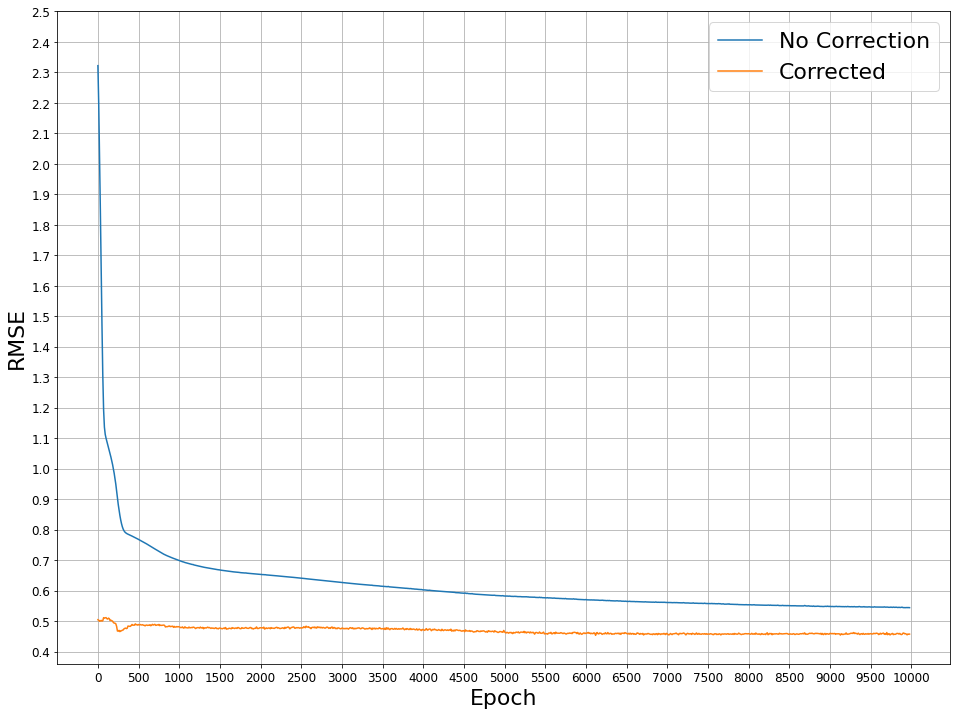

In [66]:
plot_perf("rmse", ystep=0.1)

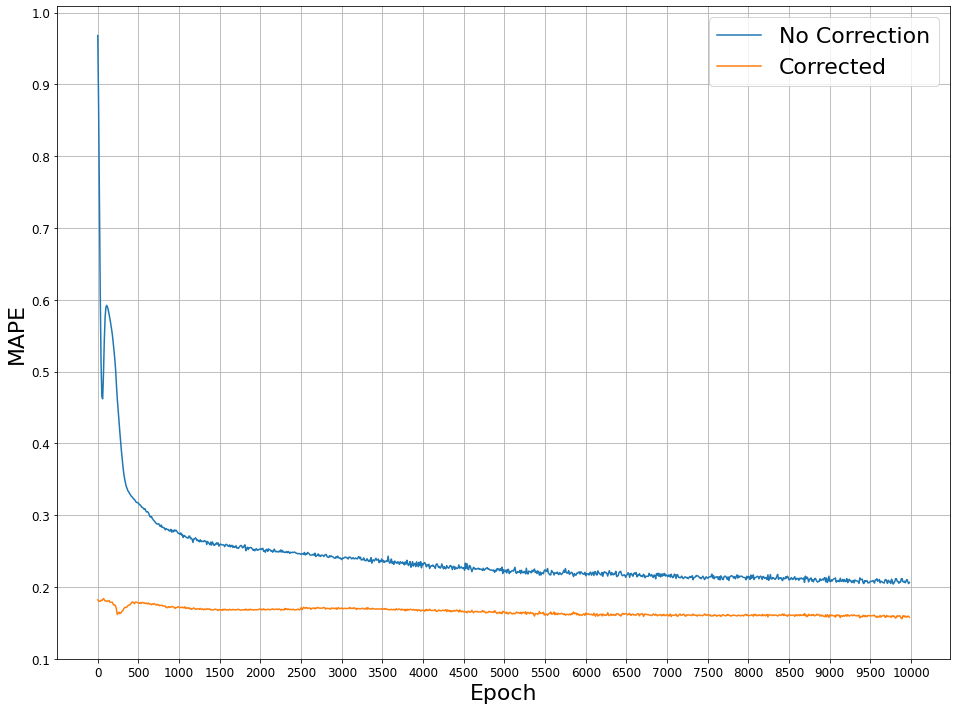

In [67]:
plot_perf("mape", ystep=0.1)

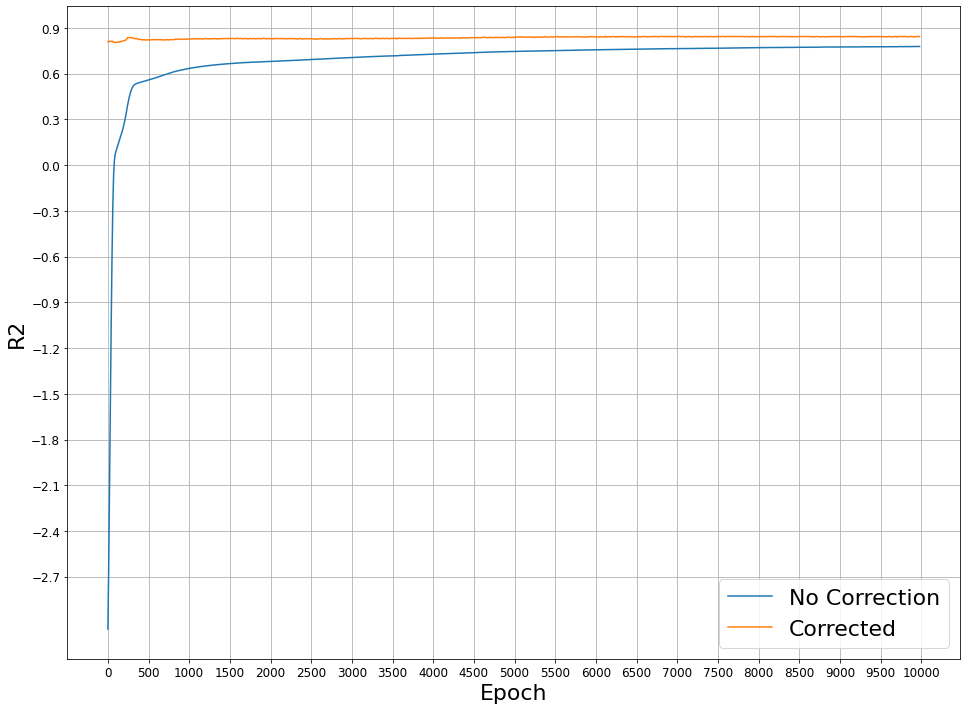

In [68]:
plot_perf("r2", ystep=0.3)